# Phase 5: Hypothesis Testing

This notebook covers three behavioral hypotheses:
1. **Recovery vs. Inertia**: Do "Rest Profiles" precede "Deep Work" or further low-performance clusters?
2. **Busy vs. Productive**: Can clustering distinguish between "High-Volume / Low-Focus" (Busywork) and "High-Volume / High-Focus" (Flow State)?
3. **Weekend Bleed**: Do Work/Study profiles intrude into weekends, and is this the strongest predictor of "Low Mood"?

In [37]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

## Load Data with Clusters

In [38]:
# Load data with cluster labels
df = pd.read_csv('data/data_with_clusters.csv')

# Ensure Date is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort by date to ensure chronological order
df = df.sort_values('Date').reset_index(drop=True)

print(f"Loaded {len(df)} days of data")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

# Cluster names (from clustering analysis)
cluster_names = {
    0: "The Commuter Grind",
    1: "The Deep Work / WFH Day",
    2: "The Distracted Recovery"
}

print("\nCluster distribution:")
print(df['KMeans_Cluster'].value_counts().sort_index())

Loaded 81 days of data
Date range: 2025-11-19 00:00:00 to 2026-02-07 00:00:00

Cluster distribution:
KMeans_Cluster
0    52
1     7
2    22
Name: count, dtype: int64


In [39]:
# Define Rest Profile (Cluster 2) and Deep Work (Cluster 1)
rest_cluster = 2  # The Distracted Recovery
deep_work_cluster = 1  # The Deep Work / WFH Day

# Find days in Rest Profile
rest_days = df[df['KMeans_Cluster'] == rest_cluster].copy()

# For each rest day, check the next day's cluster
transitions = []

for idx, row in rest_days.iterrows():
    if idx < len(df) - 1:  # Make sure there's a next day
        next_day_cluster = df.loc[idx + 1, 'KMeans_Cluster']
        transitions.append({
            'rest_date': row['Date'],
            'next_date': df.loc[idx + 1, 'Date'],
            'next_cluster': next_day_cluster,
            'transition_type': 'Rest → Deep Work' if next_day_cluster == deep_work_cluster 
                            else ('Rest → Low Performance' if next_day_cluster == rest_cluster 
                                  else 'Rest → Other')
        })

transitions_df = pd.DataFrame(transitions)

print(f"Total Rest Profile days: {len(rest_days)}")
print(f"Days with next day data: {len(transitions_df)}")
print("\nTransition counts:")
print(transitions_df['transition_type'].value_counts())

# Calculate proportions
if len(transitions_df) > 0:
    rest_to_deep_work = (transitions_df['next_cluster'] == deep_work_cluster).sum()
    rest_to_low_perf = (transitions_df['next_cluster'] == rest_cluster).sum()
    rest_to_other = len(transitions_df) - rest_to_deep_work - rest_to_low_perf
    
    print("\nTransition Proportions:")
    print(f"  Rest → Deep Work: {rest_to_deep_work}/{len(transitions_df)} ({rest_to_deep_work/len(transitions_df)*100:.1f}%)")
    print(f"  Rest → Low Performance (Rest again): {rest_to_low_perf}/{len(transitions_df)} ({rest_to_low_perf/len(transitions_df)*100:.1f}%)")
    print(f"  Rest → Other: {rest_to_other}/{len(transitions_df)} ({rest_to_other/len(transitions_df)*100:.1f}%)")

Total Rest Profile days: 22
Days with next day data: 22

Transition counts:
transition_type
Rest → Low Performance    12
Rest → Other               9
Rest → Deep Work           1
Name: count, dtype: int64

Transition Proportions:
  Rest → Deep Work: 1/22 (4.5%)
  Rest → Low Performance (Rest again): 12/22 (54.5%)
  Rest → Other: 9/22 (40.9%)


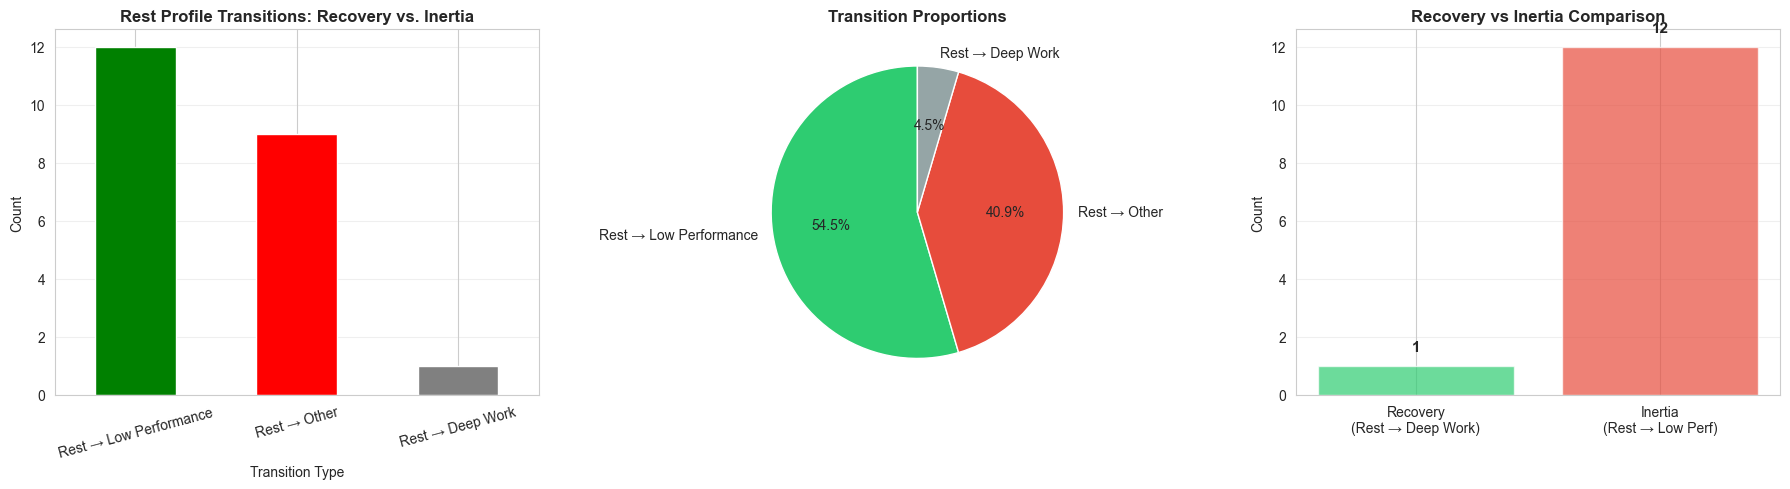

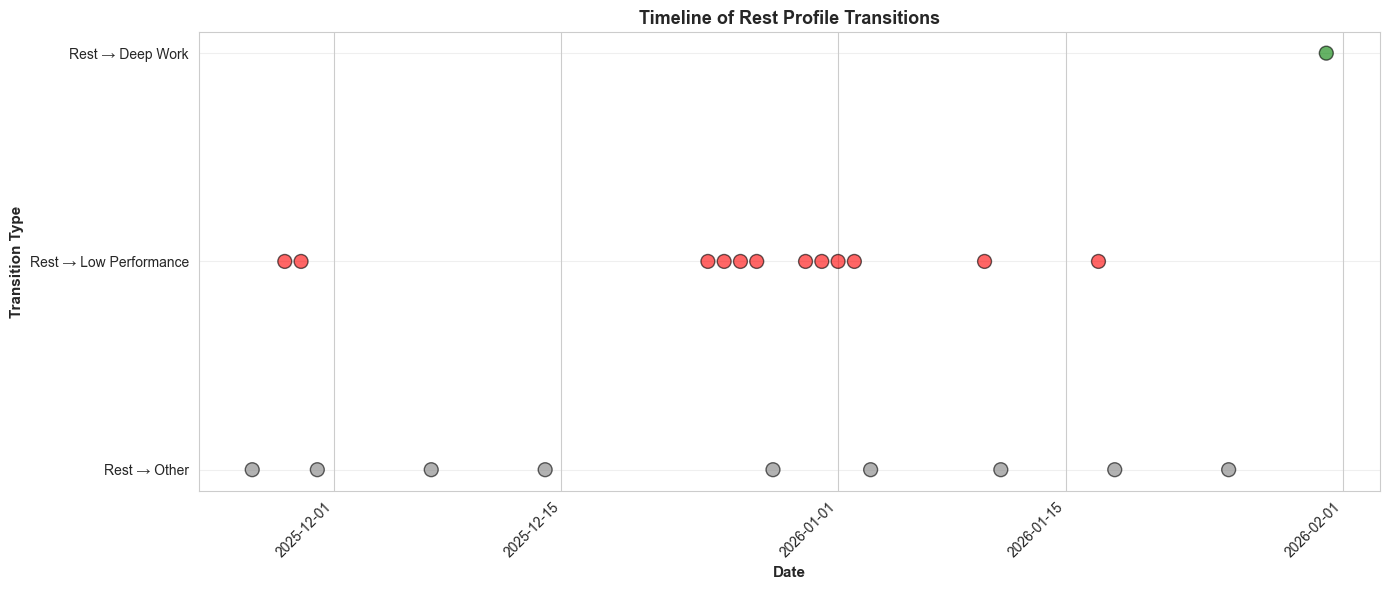

In [40]:
# Visualize transitions - Multiple Figures for Panel Presentation
transition_counts = transitions_df['transition_type'].value_counts()

# Figure 1: Multiple subplots showing different views
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Subplot 1: Bar Chart
transition_counts.plot(kind='bar', color=['green', 'red', 'gray'], ax=axes[0])
axes[0].set_title('Rest Profile Transitions: Recovery vs. Inertia', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Transition Type', fontsize=10)
axes[0].set_ylabel('Count', fontsize=10)
axes[0].tick_params(axis='x', rotation=15)
axes[0].grid(axis='y', alpha=0.3)

# Subplot 2: Pie Chart showing proportions
colors_pie = ['#2ecc71', '#e74c3c', '#95a5a6']
axes[1].pie(transition_counts.values, labels=transition_counts.index, autopct='%1.1f%%', 
             colors=colors_pie, startangle=90)
axes[1].set_title('Transition Proportions', fontsize=12, fontweight='bold')

# Subplot 3: Stacked Bar Chart (Recovery vs Inertia)
recovery_inertia = {
    'Recovery\n(Rest → Deep Work)': rest_to_deep_work,
    'Inertia\n(Rest → Low Perf)': rest_to_low_perf
}
axes[2].bar(recovery_inertia.keys(), recovery_inertia.values(), 
            color=['#2ecc71', '#e74c3c'], alpha=0.7)
axes[2].set_title('Recovery vs Inertia Comparison', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Count', fontsize=10)
axes[2].grid(axis='y', alpha=0.3)
for j, (key, val) in enumerate(recovery_inertia.items()):
    axes[2].text(j, val + 0.5, str(val), ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

# Figure 2: Transition Timeline
if len(transitions_df) > 0:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    transition_dates = transitions_df['rest_date'].values
    transition_types = transitions_df['transition_type'].values
    
    # Map transition types to y-positions
    type_map = {
        'Rest → Deep Work': 2,
        'Rest → Low Performance': 1,
        'Rest → Other': 0
    }
    y_positions = [type_map[t] for t in transition_types]
    
    # Color map
    color_map = {
        'Rest → Deep Work': 'green',
        'Rest → Low Performance': 'red',
        'Rest → Other': 'gray'
    }
    colors = [color_map[t] for t in transition_types]
    
    # Plot timeline
    ax.scatter(transition_dates, y_positions, c=colors, s=100, alpha=0.6, edgecolors='black', linewidth=1)
    
    # Add labels
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(['Rest → Other', 'Rest → Low Performance', 'Rest → Deep Work'])
    ax.set_xlabel('Date', fontsize=11, fontweight='bold')
    ax.set_ylabel('Transition Type', fontsize=11, fontweight='bold')
    ax.set_title('Timeline of Rest Profile Transitions', fontsize=13, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



## Hypothesis 5.2: Busy vs. Productive Distinction

**Hypothesis**: Can unsupervised clustering distinguish between "High-Volume / Low-Focus" days (Busywork) and "High-Volume / High-Focus" days (Flow State) based on the ratio of Work_Hours to Distraction_Time?

In [41]:
# Compute Work_Hours to Distraction_Time ratio
# Convert Distraction_Time_Mins to hours for ratio
df['Work_Distraction_Ratio'] = df['Work_Hours'] / (df['Distraction_Time_Mins'] / 60 + 0.001)  # Add small value to avoid division by zero

# Define high-volume days (top 50% of Work_Hours)
work_threshold = df['Work_Hours'].median()
df['High_Volume'] = df['Work_Hours'] >= work_threshold

# Define high-focus days (top 50% of Focus_Rating)
focus_threshold = df['Focus_Rating'].median()
df['High_Focus'] = df['Focus_Rating'] >= focus_threshold

# Categorize days
df['Productivity_Type'] = 'Low Volume'
df.loc[df['High_Volume'] & ~df['High_Focus'], 'Productivity_Type'] = 'Busywork (High Volume, Low Focus)'
df.loc[df['High_Volume'] & df['High_Focus'], 'Productivity_Type'] = 'Flow State (High Volume, High Focus)'
df.loc[~df['High_Volume'] & df['High_Focus'], 'Productivity_Type'] = 'Low Volume, High Focus'

print("Productivity Type Distribution:")
print(df['Productivity_Type'].value_counts())

print("\nProductivity Type by Cluster:")
crosstab = pd.crosstab(df['KMeans_Cluster'], df['Productivity_Type'], margins=True)
print(crosstab)

Productivity Type Distribution:
Productivity_Type
Flow State (High Volume, High Focus)    29
Low Volume, High Focus                  19
Low Volume                              18
Busywork (High Volume, Low Focus)       15
Name: count, dtype: int64

Productivity Type by Cluster:
Productivity_Type  Busywork (High Volume, Low Focus)  \
KMeans_Cluster                                         
0                                                 15   
1                                                  0   
2                                                  0   
All                                               15   

Productivity_Type  Flow State (High Volume, High Focus)  Low Volume  \
KMeans_Cluster                                                        
0                                                    29           3   
1                                                     0           7   
2                                                     0           8   
All                          

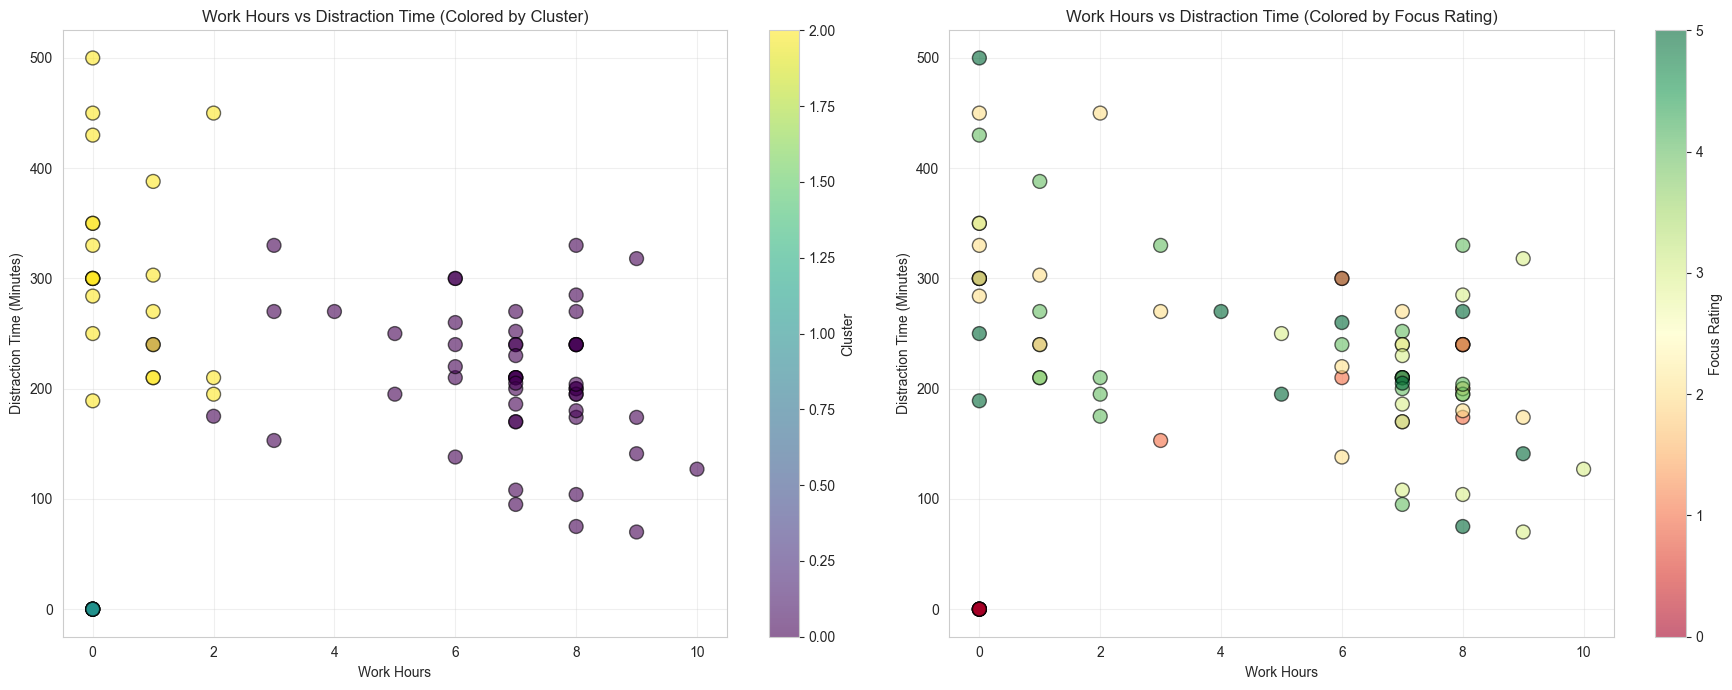

In [42]:
# Visualize Work_Hours vs Distraction_Time_Mins, colored by cluster and Focus_Rating
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Colored by cluster
scatter1 = axes[0].scatter(df['Work_Hours'], df['Distraction_Time_Mins'], 
                          c=df['KMeans_Cluster'], cmap='viridis', 
                          s=100, alpha=0.6, edgecolors='black')
axes[0].set_xlabel('Work Hours')
axes[0].set_ylabel('Distraction Time (Minutes)')
axes[0].set_title('Work Hours vs Distraction Time (Colored by Cluster)')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Plot 2: Colored by Focus_Rating
scatter2 = axes[1].scatter(df['Work_Hours'], df['Distraction_Time_Mins'], 
                          c=df['Focus_Rating'], cmap='RdYlGn', 
                          s=100, alpha=0.6, edgecolors='black')
axes[1].set_xlabel('Work Hours')
axes[1].set_ylabel('Distraction Time (Minutes)')
axes[1].set_title('Work Hours vs Distraction Time (Colored by Focus Rating)')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Focus Rating')

plt.tight_layout()
plt.show()

In [43]:
# Analyze if clusters naturally separate Busywork from Flow State
high_volume_days = df[df['High_Volume']].copy()

print("High-Volume Days Analysis:")
print("="*60)
print(f"Total high-volume days: {len(high_volume_days)}")
print("\nCluster distribution of high-volume days:")
print(high_volume_days['KMeans_Cluster'].value_counts().sort_index())

print("\nBusywork vs Flow State by Cluster:")
busywork_flow = high_volume_days.groupby('KMeans_Cluster')['Productivity_Type'].value_counts().unstack(fill_value=0)
print(busywork_flow)

# Check if clusters distinguish busywork from flow state
if 'Busywork (High Volume, Low Focus)' in busywork_flow.columns and 'Flow State (High Volume, High Focus)' in busywork_flow.columns:
    print("\nCluster separation of Busywork vs Flow State:")
    for cluster_id in busywork_flow.index:
        busywork_count = busywork_flow.loc[cluster_id, 'Busywork (High Volume, Low Focus)']
        flow_count = busywork_flow.loc[cluster_id, 'Flow State (High Volume, High Focus)']
        total = busywork_count + flow_count
        if total > 0:
            print(f"  Cluster {cluster_id} ({cluster_names[cluster_id]}):")
            print(f"    Busywork: {busywork_count}/{total} ({busywork_count/total*100:.1f}%)")
            print(f"    Flow State: {flow_count}/{total} ({flow_count/total*100:.1f}%)")

High-Volume Days Analysis:
Total high-volume days: 44

Cluster distribution of high-volume days:
KMeans_Cluster
0    44
Name: count, dtype: int64

Busywork vs Flow State by Cluster:
Productivity_Type  Busywork (High Volume, Low Focus)  \
KMeans_Cluster                                         
0                                                 15   

Productivity_Type  Flow State (High Volume, High Focus)  
KMeans_Cluster                                           
0                                                    29  

Cluster separation of Busywork vs Flow State:
  Cluster 0 (The Commuter Grind):
    Busywork: 15/44 (34.1%)
    Flow State: 29/44 (65.9%)


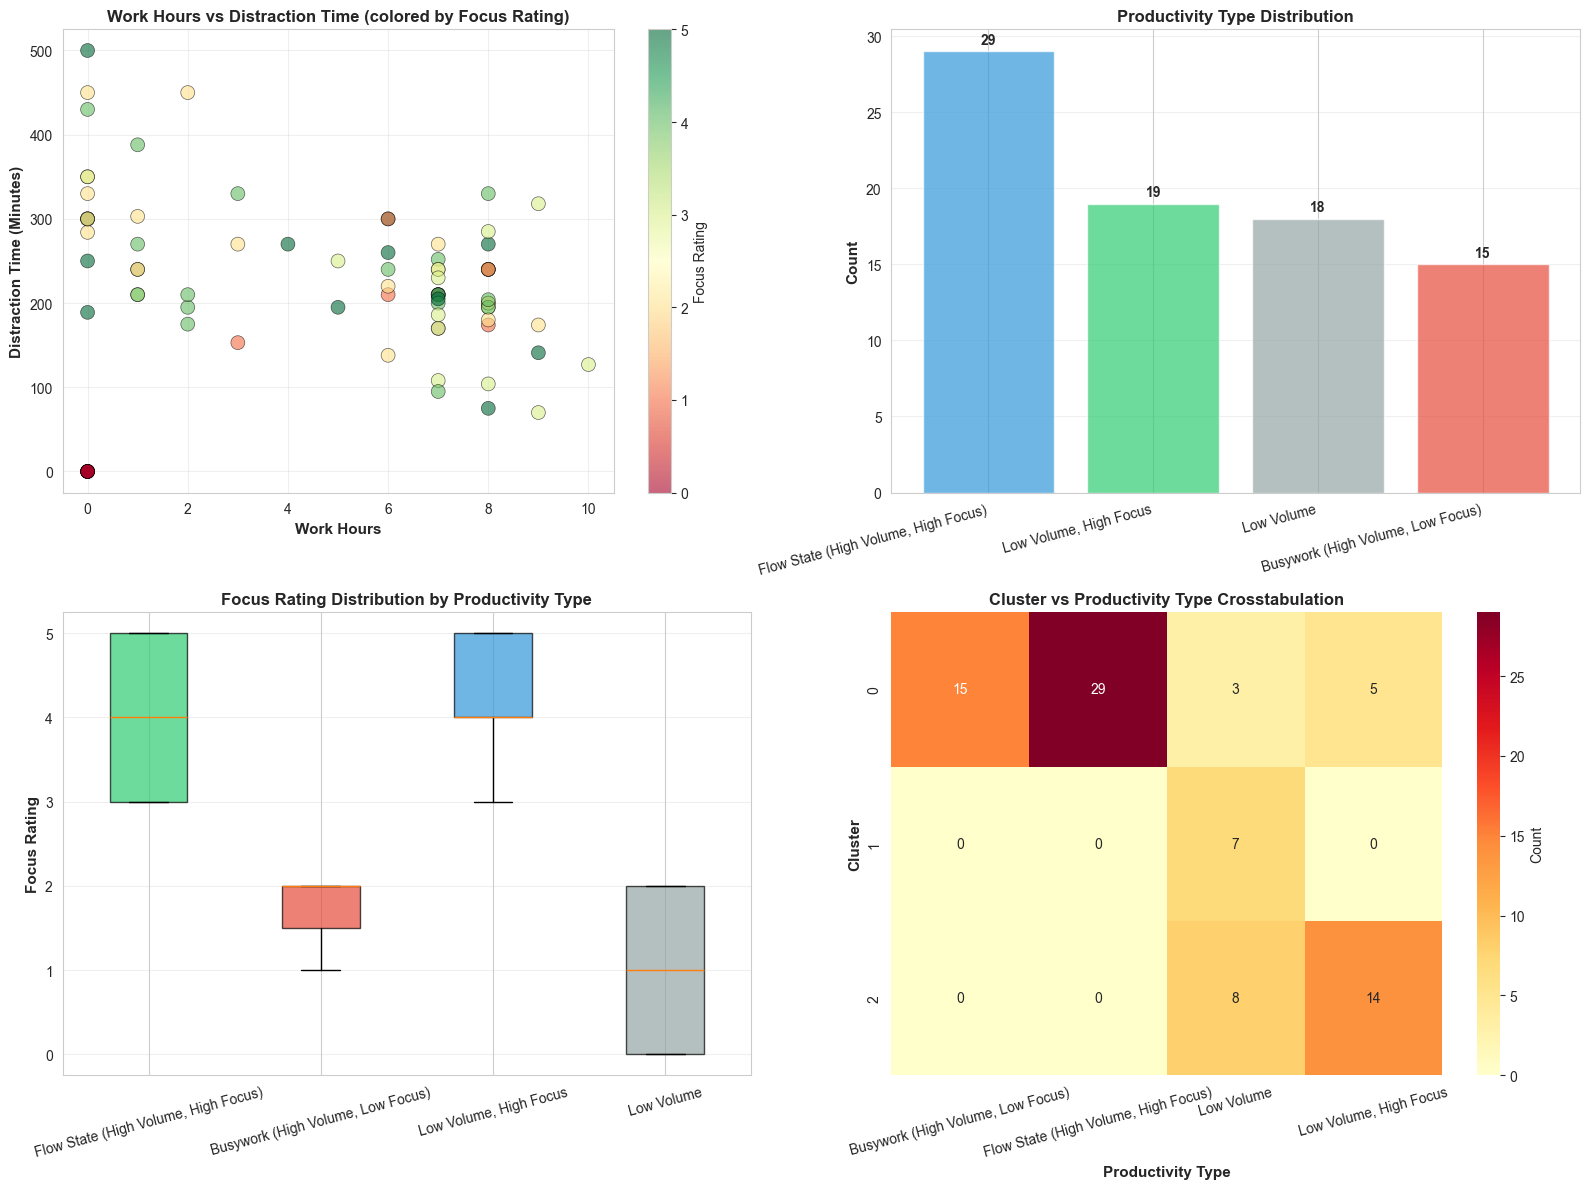

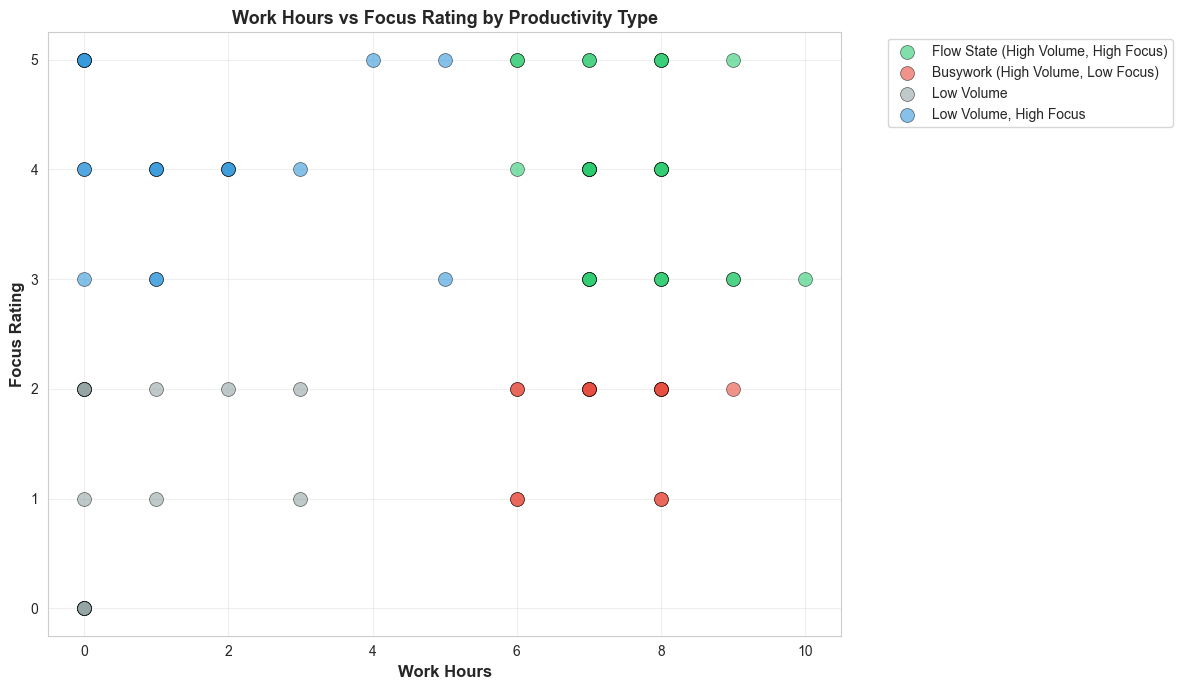

In [44]:
# Visualizations for Hypothesis 5.2: Busy vs. Productive
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Figure 1: Scatter plot - Work_Hours vs Distraction_Time colored by Focus_Rating
scatter = axes[0, 0].scatter(df['Work_Hours'], df['Distraction_Time_Mins'], 
                              c=df['Focus_Rating'], cmap='RdYlGn', 
                              s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0, 0].set_xlabel('Work Hours', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Distraction Time (Minutes)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Work Hours vs Distraction Time (colored by Focus Rating)', 
                      fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[0, 0], label='Focus Rating')

# Figure 2: Productivity Type Distribution
productivity_counts = df['Productivity_Type'].value_counts()
axes[0, 1].bar(range(len(productivity_counts)), productivity_counts.values, 
               color=['#3498db', '#2ecc71', '#95a5a6', '#e74c3c'], alpha=0.7)
axes[0, 1].set_xticks(range(len(productivity_counts)))
axes[0, 1].set_xticklabels(productivity_counts.index, rotation=15, ha='right')
axes[0, 1].set_ylabel('Count', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Productivity Type Distribution', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)
for j, val in enumerate(productivity_counts.values):
    axes[0, 1].text(j, val + 0.5, str(val), ha='center', fontweight='bold')

# Figure 3: Box plot - Focus Rating by Productivity Type
productivity_order = ['Flow State (High Volume, High Focus)', 
                      'Busywork (High Volume, Low Focus)',
                      'Low Volume, High Focus', 
                      'Low Volume']
productivity_data = [df[df['Productivity_Type'] == p]['Focus_Rating'].values 
                     for p in productivity_order if p in df['Productivity_Type'].values]
productivity_labels = [p for p in productivity_order if p in df['Productivity_Type'].values]

bp = axes[1, 0].boxplot(productivity_data, labels=productivity_labels, patch_artist=True)
colors_box = ['#2ecc71', '#e74c3c', '#3498db', '#95a5a6']
for patch, color in zip(bp['boxes'], colors_box[:len(bp['boxes'])]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1, 0].set_ylabel('Focus Rating', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Focus Rating Distribution by Productivity Type', fontsize=12, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=15)
axes[1, 0].grid(axis='y', alpha=0.3)

# Figure 4: Cluster vs Productivity Type Crosstabulation Heatmap
if 'Productivity_Type' in df.columns:
    crosstab = pd.crosstab(df['KMeans_Cluster'], df['Productivity_Type'])
    sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlOrRd', ax=axes[1, 1], 
                cbar_kws={'label': 'Count'})
    axes[1, 1].set_xlabel('Productivity Type', fontsize=11, fontweight='bold')
    axes[1, 1].set_ylabel('Cluster', fontsize=11, fontweight='bold')
    axes[1, 1].set_title('Cluster vs Productivity Type Crosstabulation', 
                          fontsize=12, fontweight='bold')
    axes[1, 1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

# Additional Figure: Work_Hours vs Focus_Rating colored by Productivity Type
fig, ax = plt.subplots(figsize=(12, 7))
productivity_types = df['Productivity_Type'].unique()
colors_map = {'Flow State (High Volume, High Focus)': '#2ecc71',
              'Busywork (High Volume, Low Focus)': '#e74c3c',
              'Low Volume, High Focus': '#3498db',
              'Low Volume': '#95a5a6'}

for ptype in productivity_types:
    mask = df['Productivity_Type'] == ptype
    ax.scatter(df[mask]['Work_Hours'], df[mask]['Focus_Rating'], 
               label=ptype, color=colors_map.get(ptype, 'gray'), 
               s=100, alpha=0.6, edgecolors='black', linewidth=0.5)

ax.set_xlabel('Work Hours', fontsize=12, fontweight='bold')
ax.set_ylabel('Focus Rating', fontsize=12, fontweight='bold')
ax.set_title('Work Hours vs Focus Rating by Productivity Type', fontsize=13, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Hypothesis 5.3: Weekend Bleed Effect

**Hypothesis**: Do specific habit profiles strictly align with calendar weekends, or do "Work/Study" profiles significantly intrude into weekends, and is this intrusion the strongest predictor of "Low Mood" clusters?

In [45]:
# Crosstab: cluster vs Is_Weekend
crosstab_weekend = pd.crosstab(df['KMeans_Cluster'], df['Is_Weekend'], 
                               margins=True, 
                               rownames=['Cluster'], 
                               colnames=['Is Weekend'])

print("Cluster Distribution by Weekend Status:")
print(crosstab_weekend)

# Calculate proportions
print("\nProportions:")
weekend_props = pd.crosstab(df['KMeans_Cluster'], df['Is_Weekend'], normalize='index') * 100
print(weekend_props.round(2))

Cluster Distribution by Weekend Status:
Is Weekend  False  True  All
Cluster                     
0              44     8   52
1               5     2    7
2               9    13   22
All            58    23   81

Proportions:
Is_Weekend      False  True 
KMeans_Cluster              
0               84.62  15.38
1               71.43  28.57
2               40.91  59.09


In [46]:
# Identify Work/Study profiles (Clusters 0 and 1)
work_study_clusters = [0, 1]  # Commuter Grind and Deep Work
df['Work_Study_Profile'] = df['KMeans_Cluster'].isin(work_study_clusters)

# Check if Work/Study profiles appear on weekends
weekend_work_study = df[df['Is_Weekend'] & df['Work_Study_Profile']]

print(f"Total weekend days: {df['Is_Weekend'].sum()}")
print(f"Weekend days with Work/Study profiles: {len(weekend_work_study)}")
print(f"Proportion: {len(weekend_work_study)/df['Is_Weekend'].sum()*100:.1f}%")

print("\nWeekend Work/Study Profile Breakdown:")
print(weekend_work_study['KMeans_Cluster'].value_counts().sort_index())

Total weekend days: 23
Weekend days with Work/Study profiles: 10
Proportion: 43.5%

Weekend Work/Study Profile Breakdown:
KMeans_Cluster
0    8
1    2
Name: count, dtype: int64


In [47]:
# Define Low Mood (bottom 50% of Mood_Rating)
mood_threshold = df['Mood_Rating'].median()
df['Low_Mood'] = df['Mood_Rating'] < mood_threshold

# Analyze Weekend + Work/Study intrusion vs Low Mood
print("Weekend Bleed Effect Analysis:")
print("="*60)

# Create categories
df['Weekend_Bleed'] = df['Is_Weekend'] & df['Work_Study_Profile']

# Compare mood across different scenarios
scenarios = {
    'Weekday + Work/Study': (~df['Is_Weekend']) & df['Work_Study_Profile'],
    'Weekend + Work/Study (Bleed)': df['Weekend_Bleed'],
    'Weekend + Rest': df['Is_Weekend'] & ~df['Work_Study_Profile'],
    'Weekday + Rest': (~df['Is_Weekend']) & ~df['Work_Study_Profile']
}

print("\nMood Rating by Scenario:")
for scenario_name, mask in scenarios.items():
    scenario_data = df[mask]
    if len(scenario_data) > 0:
        print(f"\n{scenario_name} (n={len(scenario_data)}):")
        print(f"  Mean Mood: {scenario_data['Mood_Rating'].mean():.2f}")
        print(f"  Low Mood Rate: {scenario_data['Low_Mood'].sum()}/{len(scenario_data)} ({scenario_data['Low_Mood'].mean()*100:.1f}%)")

Weekend Bleed Effect Analysis:

Mood Rating by Scenario:

Weekday + Work/Study (n=49):
  Mean Mood: 3.06
  Low Mood Rate: 17/49 (34.7%)

Weekend + Work/Study (Bleed) (n=10):
  Mean Mood: 2.80
  Low Mood Rate: 5/10 (50.0%)

Weekend + Rest (n=13):
  Mean Mood: 3.23
  Low Mood Rate: 4/13 (30.8%)

Weekday + Rest (n=9):
  Mean Mood: 3.78
  Low Mood Rate: 1/9 (11.1%)


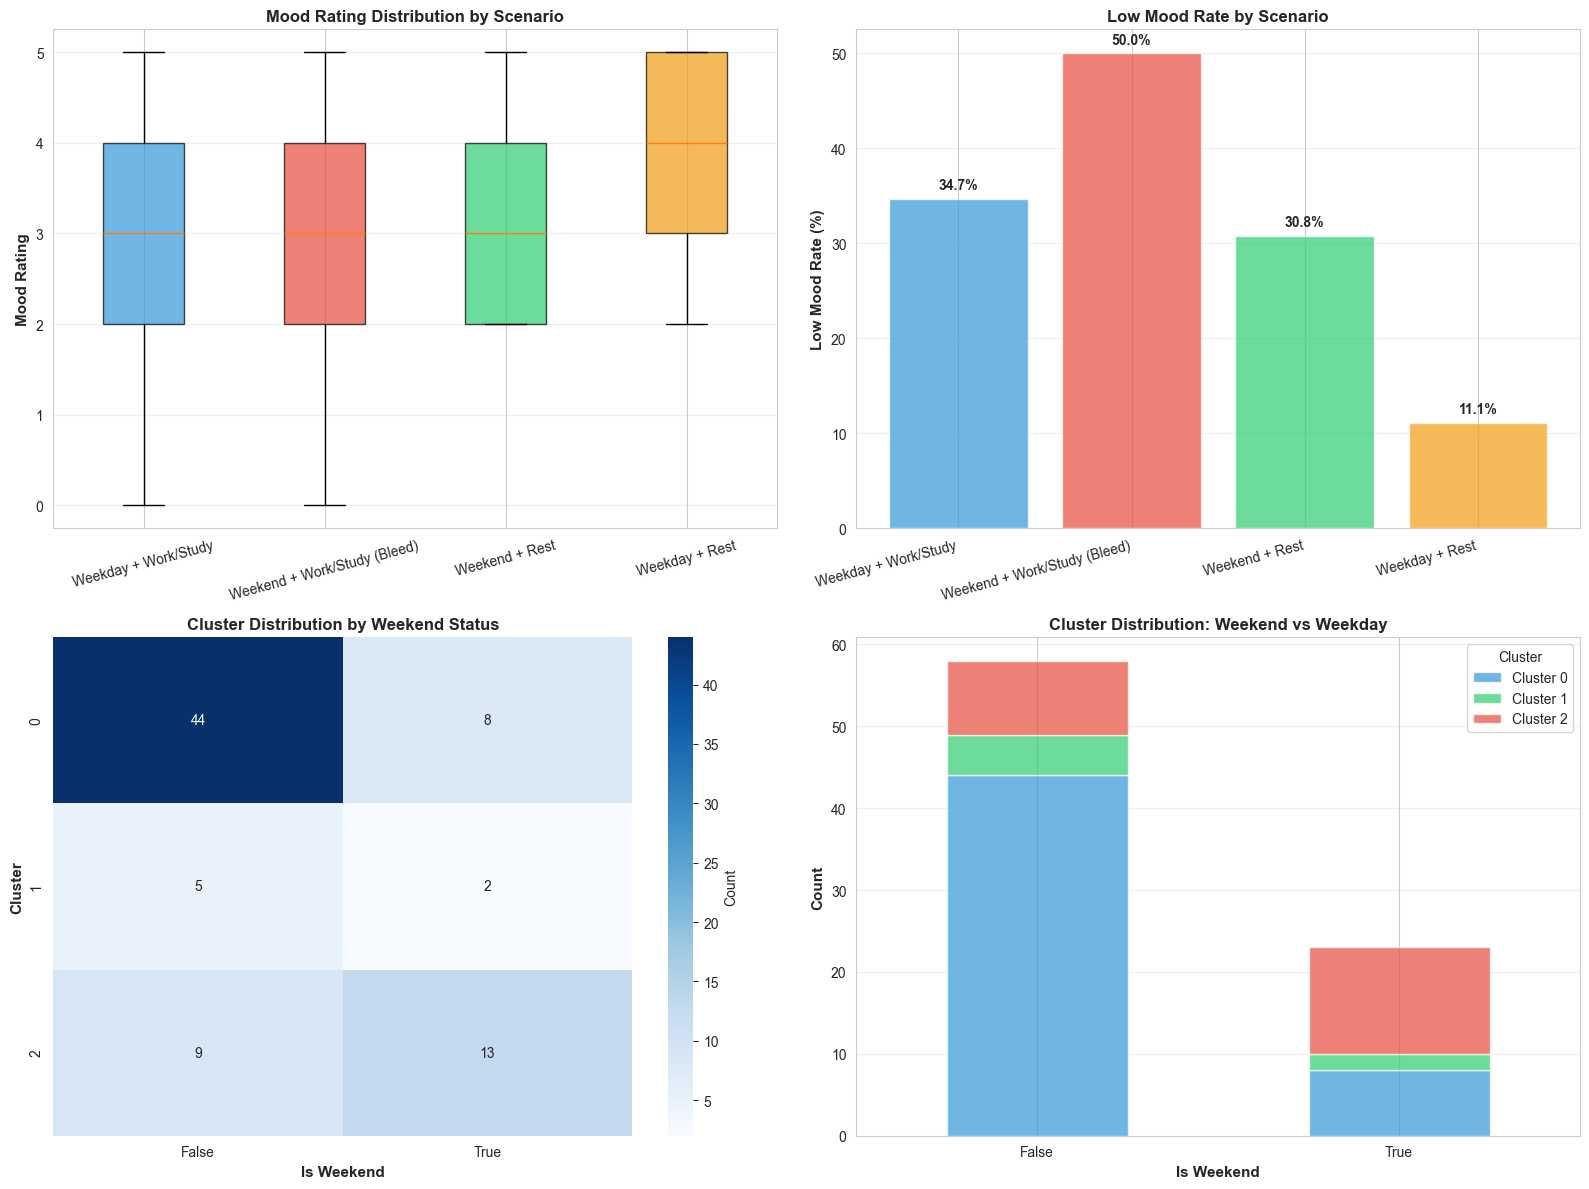

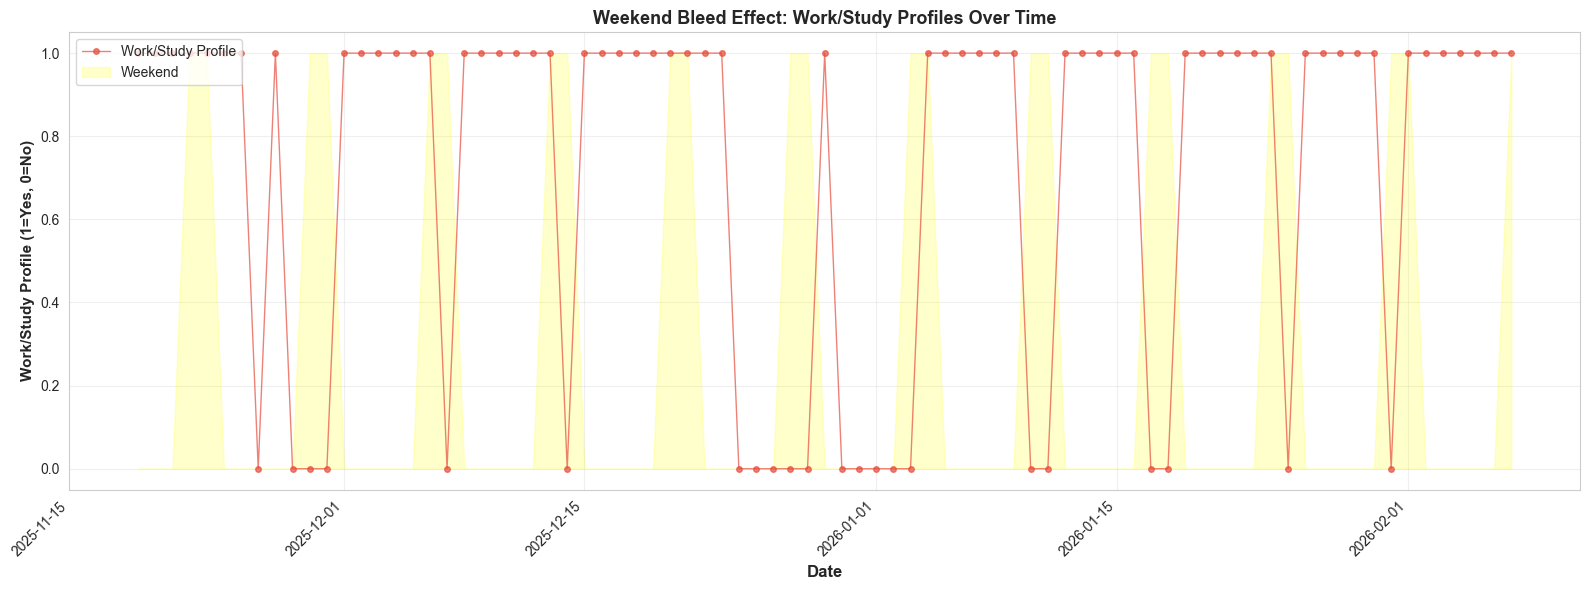

In [48]:
# Enhanced Visualizations for Hypothesis 5.3: Weekend Bleed Effect
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Figure 1: Mood Rating by Scenario (Box Plot)
scenario_moods = [df[mask]['Mood_Rating'].values for mask in scenarios.values()]
bp1 = axes[0, 0].boxplot(scenario_moods, labels=list(scenarios.keys()), patch_artist=True)
colors_scenario = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
for patch, color in zip(bp1['boxes'], colors_scenario):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[0, 0].set_ylabel('Mood Rating', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Mood Rating Distribution by Scenario', fontsize=12, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=15)
axes[0, 0].grid(axis='y', alpha=0.3)

# Figure 2: Low Mood Rate by Scenario (Bar Chart)
low_mood_rates = [df[mask]['Low_Mood'].mean() * 100 for mask in scenarios.values()]
bars = axes[0, 1].bar(range(len(scenarios)), low_mood_rates, color=colors_scenario, alpha=0.7)
axes[0, 1].set_xticks(range(len(scenarios)))
axes[0, 1].set_xticklabels(list(scenarios.keys()), rotation=15, ha='right')
axes[0, 1].set_ylabel('Low Mood Rate (%)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Low Mood Rate by Scenario', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)
for j, (bar, rate) in enumerate(zip(bars, low_mood_rates)):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, rate + 1, 
                    f'{rate:.1f}%', ha='center', fontweight='bold')

# Figure 3: Heatmap - Cluster vs Weekend Status
crosstab_weekend = pd.crosstab(df['KMeans_Cluster'], df['Is_Weekend'], 
                               rownames=['Cluster'], colnames=['Is Weekend'])
sns.heatmap(crosstab_weekend, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            cbar_kws={'label': 'Count'})
axes[1, 0].set_title('Cluster Distribution by Weekend Status', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Is Weekend', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Cluster', fontsize=11, fontweight='bold')

# Figure 4: Stacked Bar Chart - Weekend vs Weekday by Cluster
weekend_cluster = pd.crosstab(df['Is_Weekend'], df['KMeans_Cluster'])
weekend_cluster.plot(kind='bar', stacked=True, ax=axes[1, 1], 
                     color=['#3498db', '#2ecc71', '#e74c3c'], alpha=0.7)
axes[1, 1].set_title('Cluster Distribution: Weekend vs Weekday', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Is Weekend', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Count', fontsize=11, fontweight='bold')
axes[1, 1].legend(title='Cluster', labels=['Cluster 0', 'Cluster 1', 'Cluster 2'])
axes[1, 1].tick_params(axis='x', rotation=0)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Additional Figure: Time Series showing Weekend Bleed Pattern
fig, ax = plt.subplots(figsize=(16, 6))
df_sorted = df.sort_values('Date').copy()
ax.plot(df_sorted['Date'], df_sorted['Work_Study_Profile'].astype(int), 
        marker='o', markersize=4, linestyle='-', linewidth=1, 
        label='Work/Study Profile', color='#e74c3c', alpha=0.7)
ax.fill_between(df_sorted['Date'], 0, df_sorted['Is_Weekend'].astype(int), 
                alpha=0.2, color='yellow', label='Weekend')
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Work/Study Profile (1=Yes, 0=No)', fontsize=11, fontweight='bold')
ax.set_title('Weekend Bleed Effect: Work/Study Profiles Over Time', fontsize=13, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Summary of Hypothesis Tests

In [49]:
# Compile summary
print("="*80)
print("HYPOTHESIS TESTING SUMMARY")
print("="*80)

print("\n1. Recovery vs. Inertia Hypothesis:")
if len(transitions_df) > 0:
    recovery_rate = rest_to_deep_work / len(transitions_df) * 100
    inertia_rate = rest_to_low_perf / len(transitions_df) * 100
    print(f"   Rest → Deep Work: {recovery_rate:.1f}%")
    print(f"   Rest → Low Performance: {inertia_rate:.1f}%")
    print(f"   Conclusion: {'Recovery' if recovery_rate > inertia_rate else 'Inertia'} pattern dominates")

print("\n2. Busy vs. Productive Distinction:")
print(f"   High-volume days: {len(high_volume_days)}")
if 'Busywork (High Volume, Low Focus)' in df['Productivity_Type'].values:
    busywork_count = (df['Productivity_Type'] == 'Busywork (High Volume, Low Focus)').sum()
    flow_count = (df['Productivity_Type'] == 'Flow State (High Volume, High Focus)').sum()
    print(f"   Busywork days: {busywork_count}")
    print(f"   Flow State days: {flow_count}")

print("\n3. Weekend Bleed Effect:")
print(f"   Weekend days with Work/Study profiles: {len(weekend_work_study)}/{df['Is_Weekend'].sum()} ({len(weekend_work_study)/df['Is_Weekend'].sum()*100:.1f}%)")
if len(weekend_bleed_mood) > 0 and len(weekend_rest_mood) > 0:
    print(f"   Weekend Bleed Mood: {weekend_bleed_mood.mean():.2f}")
    print(f"   Weekend Rest Mood: {weekend_rest_mood.mean():.2f}")
    print(f"   {'Weekend Bleed' if weekend_bleed_mood.mean() < weekend_rest_mood.mean() else 'No clear'} effect on mood")

HYPOTHESIS TESTING SUMMARY

1. Recovery vs. Inertia Hypothesis:
   Rest → Deep Work: 4.5%
   Rest → Low Performance: 54.5%
   Conclusion: Inertia pattern dominates

2. Busy vs. Productive Distinction:
   High-volume days: 44
   Busywork days: 15
   Flow State days: 29

3. Weekend Bleed Effect:
   Weekend days with Work/Study profiles: 10/23 (43.5%)
   Weekend Bleed Mood: 2.80
   Weekend Rest Mood: 3.23
   Weekend Bleed effect on mood


## Save Results

In [50]:
# Save updated dataframe with hypothesis analysis columns
df.to_csv('data/data_with_hypothesis_analysis.csv', index=False)

# Save transitions data
transitions_df.to_csv('data/recovery_inertia_transitions.csv', index=False)

print("Results saved:")
print("- data/data_with_hypothesis_analysis.csv")
print("- data/recovery_inertia_transitions.csv")

Results saved:
- data/data_with_hypothesis_analysis.csv
- data/recovery_inertia_transitions.csv
